# READ ME

#### This notebook is implemeted in a repository in github with input and output folders.
#### It has 2 parts:
##### > Part 1: Pre-defined funtions for each technique.
##### > Part 2: Execution of model pipelines, here users can modify which combination of techniques they want to run. The scores will be printed as a csv in output folders. 

# PART 1: FUNCTIONS

## Import library

In [25]:
#importing libraries
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from BorutaShap import BorutaShap
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

from collections import Counter
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, log_loss, cohen_kappa_score, make_scorer

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical 

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

import plotly.express as px
import visualkeras

## Read df

In [26]:
#this function is to read, transform and join 2 data frame

def read_features():
    path = 'input/secom.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['feature_'+str(x+1) for x in range(len(df.columns))]
    return df


def read_target():
    path = 'input/secom_labels.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['status','timestamp']
    df['timestamp'] = pd.to_datetime(df['timestamp'],dayfirst=True)
    return df


## Remove duplicated columns

In [27]:
#find the duplicated features (columns)
def remove_duplicated_columns(df):
    list_duplicate = []
    to_remove = []
    for i in range(0, len(df.columns)):
        l = []
        for j in range(i+1,len(df.columns)):
            if df.iloc[:,i].equals(df.iloc[:,j]) == True:
                if j not in list_duplicate:
                    l.append(j)
                    to_remove.append('feature_'+str(j+1))
                list_duplicate.append(i)
                list_duplicate.append(j)

    return df.drop(columns=to_remove, axis = 1)

# X = remove_duplicated_columns(X)
# X.shape


## Remove columns with Constant volatility (std=0)

In [28]:
def remove_constant_volatility(df):
    df_EDA= df.describe().T
    df_EDA= df_EDA[df_EDA["std"] == 0]
    df = df.drop(axis=1, columns=df_EDA.index)
    return df

# X = remove_constant_volatility(X)
# X.shape

## Remove columns with high %Missing values

In [29]:
def remove_cols_with_high_pct_null(df, null_threshold):
    list_column_with_pct_null = pd.concat([df.isnull().sum(), df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    list_column_with_pct_null= list_column_with_pct_null[list_column_with_pct_null["Percentage (%)"] >= null_threshold]
    df = df.drop(axis=1, columns=list_column_with_pct_null.index)
    return df

# X = remove_cols_with_high_pct_null(X, 0.8)
# X.shape

## Split data

In [30]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1,stratify=y)

## Outlier treatment

In [31]:
#how = ['NaN', '3s' ,'nothing']
def replace_outlier(df, how):
    for col in df:
        ll_col = df[col].mean() - 3 * df[col].std()
        ul_col = df[col].mean() + 3 * df[col].std()
        if how == 'NaN':
            df[col] = np.where(df[col]>ul_col,np.NaN,np.where(df[col]<ll_col,np.NaN,df[col]))
        elif how == '3s':
            df[col] = np.where(df[col]>ul_col,ul_col,np.where(df[col]<ll_col,ll_col,df[col]))
    return df

## Missing value Imputation

In [32]:
#which_weights = ['distance','uniform']

def impute_null_with_knn(X_train, X_test, which_weights):
    #First scale the data 
    scaler = MinMaxScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns= X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns= X_test.columns)

    knn = KNNImputer(n_neighbors=5, weights=which_weights) #check this neighbors = 5

    X_train = pd.DataFrame(knn.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(knn.transform(X_test), columns=X_test.columns)
    
    X_train = pd.DataFrame(scaler.inverse_transform(X_train), columns= X_train.columns)
    X_test = pd.DataFrame(scaler.inverse_transform(X_test), columns= X_test.columns)
    return X_train, X_test

#X_train = impute_null_with_knn(X_train)

In [33]:
def impute_null_with_mice(X_train, X_test): 
    imp = IterativeImputer(max_iter=5, verbose=0, imputation_order='roman', random_state=0)
    X_train = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(imp.transform(X_test), columns=X_test.columns)
    return X_train, X_test

## Feature Selection

In [34]:
#This is BorutaShap with TENTATIVE features

#list_method=['shap','gini']

def BorutaShap_FS (X, y, method_option) :
    #modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, class_weight='balanced_subsample', max_depth=5, random_state=100)
    modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, max_depth=5, random_state=100)

    # define model for resp. classifier
    modelshap.fit(X,y)
    feature_names = np.array(X.columns)
    # define Boruta Sahp feature selection method
    feature_selector = BorutaShap(model=modelshap,
                              importance_measure=method_option,
                              classification=True)  # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = False,random_state=100)  
    #feature_selector.plot(which_features='accepted',figsize=(20,10))
    tentative=X.loc[:,feature_selector.tentative]
    selected=feature_selector.Subset()
    selten=pd.concat([selected,tentative],axis=1)
    # call transform() on X to filter it down to selected features
    return  selten

In [35]:
#RFE

#classifier = ['RF', 'SVM']

def RFE_FS (X, y,classify) :
    scaler = MinMaxScaler()
    X_scaled= pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    feature_names = np.array(X_scaled.columns)
    if classify == 'RF':
    # define random forest classifier
        model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
       
    if classify== 'SVM':
        model = SVC(kernel='linear',C=5)
        #rfe = RFECV(estimator = model,scoring='accuracy')
    # find all relevant features
    model.fit(X_scaled, y)
    rfe = RFE(estimator = model,n_features_to_select = 30)
    rfe.fit(X_scaled,y)

     # zip feature names, ranks, and decisions 
    feature_ranks = list(zip(feature_names, 
                             rfe.ranking_, 
                             rfe.support_))

    final_features_rfe = list()
    indexes = np.where(rfe.ranking_ <= 2)
    for x in np.nditer(indexes):
        final_features_rfe.append(feature_names[x])
    
    
    # unscale the data before return
    X_unscaled=pd.DataFrame(scaler.inverse_transform(X_scaled), columns=X_scaled.columns)
    ff_rfe=pd.DataFrame(X_unscaled.filter(final_features_rfe))
    

 # call transform() on X to filter it down to selected features
    return  ff_rfe

In [36]:
#Boruta function with random forest

def BorutaPy_FS (X, y) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
    model.fit(X, y)
    # define Boruta feature selection method
    
    feature_selector = BorutaPy(model, n_estimators='auto', verbose=0, random_state=100, max_iter=140)

    # find all relevant features
    feature_selector.fit(X.to_numpy(),y)

        
    final_features = list()
    indexes = np.where(feature_selector.ranking_ <= 2) #change to 2
    for x in np.nditer(indexes):
        final_features.append(feature_names[x])
    
 # call transform() on X to filter it down to selected features
    return pd.DataFrame(X.filter(final_features))

## Balancing

In [37]:
def sampling(X_train, y_train, sampler):
    
    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)    
    
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100, shrinkage=1)

    #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100)
    

    #SMOTTEENN
    if sampler == 'SMOTEENN' :
        sampler = SMOTEENN(random_state=100)
        
        
    #Random under Sampling
    if sampler == "randomunder":
        sampler = RandomUnderSampler(random_state=100)

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    #counter = Counter(y_resampled)
    #print(counter)
    
    return X_resampled, y_resampled

# X_train, y_train = sampling(X_train, y_train,'SMOTE')
# X_train.shape

## Model: Deep Neural Network

#Note:
<br>How to Use Keras Models in scikit-learn:
<br>-Keras models can be used in scikit-learn by wrapping them with the KerasClassifier or KerasRegressor class.
<br>-To use these wrappers you must define a function that creates and returns your Keras sequential model, then pass this function to the build_fn argument when constructing the KerasClassifier class.
<br>https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/


In [38]:
#the accuracy that is produced by keras is similar to the one being manually calculated by argmax, same with scikit learn evaluate
#grid seach does not build to apply on test set, after finding the best hyperparamter, we need to fit the model on train set again and use it for test set

#### Building the model

In [40]:
def create_model_NN(batch_size=100, epochs=50, activation='linear', dropout_rate=0.0, neurons=10):

    input_dim = X_train.shape[1]

    model = Sequential()
    model.add(Dense(round((input_dim+2)/2)*neurons, activation=activation, input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    #model.add(Dense(round((neurons*5+2)/2), activation=activation))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    return model

#### Create combinations of Hyperparameters for "Grid-search"

In [47]:
#create a listf of dictionary of params
search_params=[]

# batch_size = [100, 150, 200,500]
# epochs = [10, 20, 50, 100]
# activation = ['linear','softmax','relu'] 
# dropout_rate = [0,0.1,0.3,0.5]
# neurons = [0.5,1,1.5,2]

batch_size = [100]
epochs = [10]
activation = ['linear'] 
dropout_rate = [0,0.1]
neurons = [1,2]

#create a dictionary of hyperparameter combinations
for b in batch_size:
    for e in epochs:
        for a in activation:
            for d in dropout_rate:
                for n in neurons:
                    search_params.append({'batch_size':b,'epochs':e,'activation':a,'dropout_rate':d,'neurons':n})


# PART 2: EXECUTION

### 2.1 PRE-MODEL TREATEMENT

In [64]:
#step 1:
# reading data
X = read_features()
y = read_target().iloc[:,0]
#split data into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify=y)

# step 2:
X_train = remove_duplicated_columns(X_train)

#step 3:
X_train = remove_constant_volatility(X_train)

#step 4:
X_train = remove_cols_with_high_pct_null(X_train, 0.5) #this can be in the loop too, may be later
#step 5: remove the same columns from step 2-4 TRAIN_TEST split
X_test = X_test.loc[:,X_train.columns]

#step 6: oulier treatement (on both TRAIN & TEST split)
X_train = replace_outlier(X_train, '3s')
X_test = replace_outlier(X_test, '3s')

#step 7: missing value imputation (on both TRAIN & TEST split)
X_train, X_test = impute_null_with_knn(X_train, X_test, 'distance')

#step 8: feature selection (on both TRAIN & TEST split)
X_train = BorutaShap_FS(X_train, y_train, 'shap')

#make test set have the SAME features as train set
X_test = X_test.loc[:,X_train.columns]

#step 9: balancing only on TRAIN split
X_train, y_train = sampling(X_train, y_train, 'SMOTEENN')

# prepare the y set: to_categorical cannot work with negative numbers
y_train = y_train.replace(-1, 0)
y_test = y_test.replace(-1, 0)
#one hot encode outputs
y_train_c = to_categorical(y_train)
y_test_c = to_categorical(y_test)

100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


In [56]:
y_test.shape

(314,)

In [65]:
X_test.shape

(314, 16)

In [66]:
y_train.shape

(1845,)

In [67]:
y_train_c

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [68]:
y_train_c.shape

(1845, 2)

In [69]:
X_train.shape

(1845, 16)

### 2.2 FITTING MODELS

Note:
<br>I built my one grid search because the existing library from Keras and sciki-learn cannot record all the metrics that I need

In [80]:
#initiate the metrics as empty list, these metrics will be exported into csv later

train_cf_matrix=[]
train_accuracy=[]
train_f1=[]
train_precision=[]
train_recall=[]
train_auc=[]
train_type_1_error_FP=[]
train_type_2_error_FN=[]
train_log_loss=[]
train_cohen_kappa_score=[]

test_cf_matrix=[]
test_accuracy=[]
test_f1=[]
test_precision=[]
test_recall=[]
test_auc=[]
test_type_1_error_FP=[]
test_type_2_error_FN=[]
test_log_loss=[]
test_cohen_kappa_score=[]

hyperparam = []
l_batch_size = []
l_epochs = []
l_activation = []
l_dropout_rate = []
l_neurons = []

#initiat a dictionary to store the scores
dict_scores = {}


skf = StratifiedKFold(n_splits = 5, random_state = 1, shuffle = True) 


fold = 0
#create temp variables to store the original values before applying CV
X_train_temp = X_train
X_test_temp = X_test
y_train_c_temp = y_train_c
y_test_c_temp = y_test_c

for train_index, test_index in skf.split(X_train, y_train): #here I use y_train instead of y_train_c because skf.split should read binary value
    X_train, X_test = X_train_temp.iloc[train_index,], X_test_temp.iloc[test_index,] #.iloc because this is pandas df not numpy array
    y_train_c, y_test_c = y_train_c_temp.iloc[train_index,], y_test_c_temp.iloc[test_index,]

    for p in search_params:
        real_model = create_model_NN(**p) #p are set of parameters that have been created by the for-loops above
        real_model.fit(X_train,y_train_c, epochs= p['epochs'], batch_size = p['batch_size'], verbose=0)
        
        #record the papameters to export into csv later
        l_batch_size.append(p['batch_size'])
        l_epochs.append(p['epochs'])
        l_activation.append(p['activation'])
        l_dropout_rate.append(p['dropout_rate'])
        l_neurons.append(p['neurons'])   
        hyperparam.append(p)


        #create predicted y
        y_pred = real_model.predict(X_train)
        #Converting y-predicted to labels
        pred = list()
        for i in range(len(y_pred)):
            pred.append(np.argmax(y_pred[i]))

        #Converting y-test to labels
        test = list()
        for i in range(len(y_train_c)):
            test.append(np.argmax(y_train_c[i]))

        train_cf_matrix.append(confusion_matrix(test, pred))
        train_accuracy.append(accuracy_score(test, pred)) #these are library from scikit learn, this yield the same result as the one of keras mode.evaluate()
        train_f1.append(f1_score(test, pred)) 
        train_precision.append(precision_score(test, pred))
        train_recall.append(recall_score(test, pred))
        train_auc.append(roc_auc_score(test, pred))
        train_type_1_error_FP.append(confusion_matrix(test, pred)[0][1])
        train_type_2_error_FN.append(confusion_matrix(test, pred)[1][0])
        train_log_loss.append(log_loss(test, pred))
        train_cohen_kappa_score.append(cohen_kappa_score(test, pred))


        #create predicted y
        y_pred = real_model.predict(X_test)
        #Converting y-predicted to labels
        pred = list()
        for i in range(len(y_pred)):
            pred.append(np.argmax(y_pred[i]))

        #Converting y-test to labels
        test = list()
        for i in range(len(y_test_c)):
            test.append(np.argmax(y_test_c[i]))
            
        test_cf_matrix.append(confusion_matrix(test, pred))
        test_accuracy.append(accuracy_score(test, pred)) #these are library from scikit learn, this yield the same result as the one of keras mode.evaluate()
        test_f1.append(f1_score(test, pred)) 
        test_precision.append(precision_score(test, pred))
        test_recall.append(recall_score(test, pred))
        test_auc.append(roc_auc_score(test, pred))
        test_type_1_error_FP.append(confusion_matrix(test, pred)[0][1])
        test_type_2_error_FN.append(confusion_matrix(test, pred)[1][0])
        test_log_loss.append(log_loss(test, pred))
        test_cohen_kappa_score.append(cohen_kappa_score(test, pred))


    #create a dict of list
    dict_scores['hyperparam'] = hyperparam

    dict_scores['batch_size'] = l_batch_size
    dict_scores['epochs'] = l_epochs
    dict_scores['activation'] = l_activation
    dict_scores['dropout_rate'] = l_dropout_rate
    dict_scores['neurons'] = l_neurons


    dict_scores['train_cf_matrix']=train_cf_matrix
    dict_scores['train_accuracy']=train_accuracy
    dict_scores['train_f1']=train_f1
    dict_scores['train_precision']=train_precision
    dict_scores['train_recall']=train_recall
    dict_scores['train_auc']=train_auc
    dict_scores['train_type_1_error_FP']=train_type_1_error_FP
    dict_scores['train_type_2_error_FN']=train_type_2_error_FN
    dict_scores['train_log_loss']=train_log_loss
    dict_scores['train_cohen_kappa_score']=train_cohen_kappa_score

    dict_scores['test_cf_matrix']=test_cf_matrix
    dict_scores['test_accuracy']=test_accuracy
    dict_scores['test_f1']=test_f1
    dict_scores['test_precision']=test_precision
    dict_scores['test_recall']=test_recall
    dict_scores['test_auc']=test_auc
    dict_scores['test_type_1_error_FP']=test_type_1_error_FP
    dict_scores['test_type_2_error_FN']=test_type_2_error_FN
    dict_scores['test_log_loss']=test_log_loss
    dict_scores['test_cohen_kappa_score']=test_cohen_kappa_score


    df_scores = pd.DataFrame.from_dict(dict_scores)
    df_scores.to_csv('output/scores_with_FS_TESTING_fold'+str(fold)+'.csv')

IndexError: positional indexers are out-of-bounds

#### Export results to csv

### 2.3 CROSS-VALIDATION

In [ ]:
#https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
#https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538

In [44]:
 skf = StratifiedKFold(n_splits = 5, random_state = 10, shuffle = True) 

for train_index, test_index in skf.split(X_train, y_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X[train_index], X[test_index]
    #y_train, y_test = y[train_index], y[test_index]

TRAIN: [   0    1    2 ... 1842 1843 1844] TEST: [   6   10   18   20   21   22   24   38   61   71   72   75   90   95
  101  103  105  108  113  116  117  118  124  131  147  150  152  155
  160  161  163  170  178  186  201  204  207  209  215  223  226  231
  236  241  242  243  246  253  255  258  261  265  281  285  293  295
  300  304  307  310  311  312  320  326  329  330  334  336  343  344
  347  351  352  355  356  361  369  371  377  382  385  391  405  406
  412  414  420  422  427  431  433  435  448  467  469  471  475  483
  484  489  490  493  497  500  518  521  524  530  532  545  554  556
  561  562  563  573  577  580  589  596  597  599  624  629  631  633
  640  641  647  648  654  656  657  673  680  689  691  694  699  703
  706  712  718  724  726  733  736  744  747  748  752  756  759  760
  763  769  779  783  784  789  793  794  798  802  805  813  814  823
  826  827  832  836  837  848  849  852  856  857  858  872  873  882
  884  897  901  912  913  9

# PART 3: Visualization

In [21]:
%pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 32.9 MB/s eta 0:00:0000:0100:01
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [22]:
import plotly.express as px

In [1]:
import re
import pandas as pd
import seaborn as sns
import plotly.express as px
import visualkeras
import re
pd.set_option('display.max_columns', None)

In [6]:
#architecture of the NN model, input layer is not really considered a NN layer
visualkeras.layered_view(real_model, legend=True, draw_volume=True) 

NameError: name 'real_model' is not defined

In [10]:
#There are 2 files contain data scores, one with and one without FS
df_scores_with_FS = pd.read_csv('df_scores_with_FS.csv')
df_scores_no_FS = pd.read_csv('df_scores_no_FS.csv')
df_scores_with_FS['FS']=True
df_scores_no_FS['FS']=False

#merge the 2 files contaiing scores together
df_scores = pd.concat([df_scores_with_FS, df_scores_no_FS], ignore_index=True)


In [13]:
#we did not save the type 1 & type 2 errors in the csv, that's why we need to extract them from the CFM column now
df_scores['train_Type1_FP'] = df_scores.apply(lambda row: re.findall(r'[0-9]+',row['train_cf_matrix'])[1], axis=1).astype('int')
df_scores['train_Type2_FN'] = df_scores.apply(lambda row: re.findall(r'[0-9]+',row['train_cf_matrix'])[2], axis=1).astype('int')
df_scores['test_Type1_FP'] = df_scores.apply(lambda row: re.findall(r'[0-9]+',row['test_cf_matrix'])[1], axis=1).astype('int')
df_scores['test_Type2_FN'] = df_scores.apply(lambda row: re.findall(r'[0-9]+',row['test_cf_matrix'])[2], axis=1).astype('int')
#syntax: matches = re.findall(pattern,str) -> return a list of matched words (not index)

cost_Type1_FP = 1
cost_Type2_FN = 20
df_scores['test_cost'] = df_scores['test_Type1_FP']*cost_Type1_FP + df_scores['test_Type2_FN']*cost_Type2_FN
df_scores['train_cost'] = df_scores['train_Type1_FP']*cost_Type1_FP + df_scores['train_Type2_FN']*cost_Type2_FN


In [14]:
df_scores.head(1)

,Unnamed: 0,hyperparam,batch_size,epochs,activation,dropout_rate,neurons,train_cf_matrix,train_accuracy,train_f1,...,test_auc,test_log_loss,test_cohen_kappa_score,FS,train_Type1_FP,train_Type2_FN,test_Type1_FP,test_Type2_FN,test_cost,train_cost
0,0,"{'batch_size': 100, 'epochs': 10, 'activation'...",100,10,linear,0.0,0.5,[[386 372]\n [297 790]],0.637398,0.702534,...,0.507639,17.48976,0.003751,True,372,297,149,10,349,6312


<AxesSubplot:xlabel='test_Type1_FP', ylabel='test_Type2_FN'>

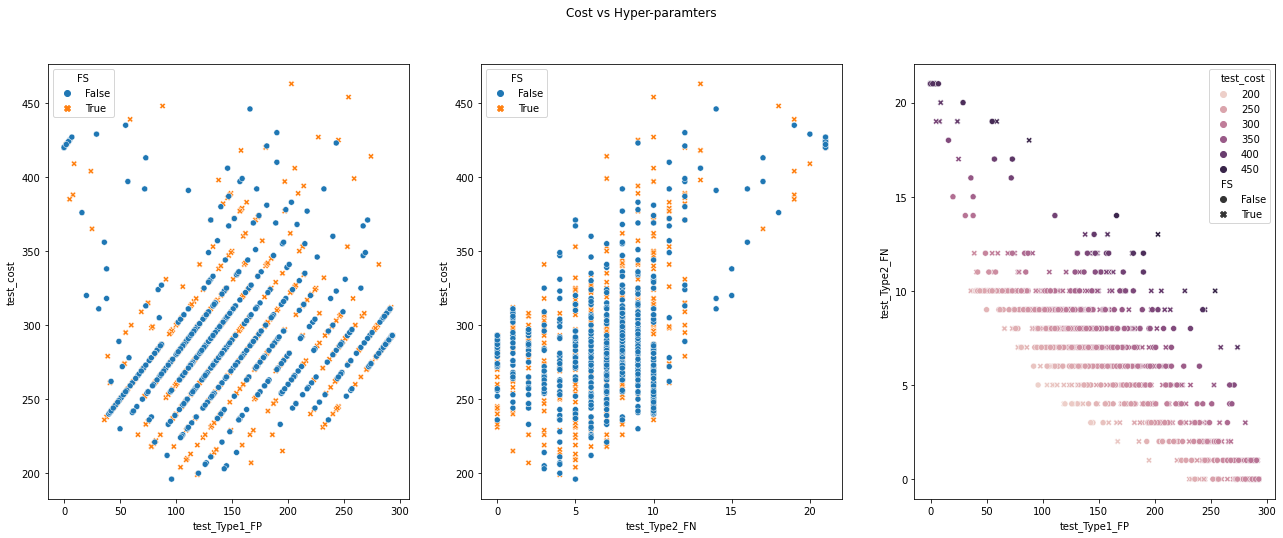

In [15]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 3, figsize=(22, 8))

fig.suptitle('Cost vs Hyper-paramters')
sns.scatterplot(ax=axes[0], data=df_scores, x='test_Type1_FP', y='test_cost', style='FS', hue='FS')
sns.scatterplot(ax=axes[1], data=df_scores, x='test_Type2_FN', y='test_cost', style='FS', hue='FS')
sns.scatterplot(ax=axes[2], data=df_scores, x='test_Type1_FP', y='test_Type2_FN', style='FS', hue='test_cost')


In [54]:
#find out the best model
df_scores.sort_values(by='test_cost', ascending=True).head(5)

,Unnamed: 0,hyperparam,batch_size,epochs,activation,dropout_rate,neurons,train_cf_matrix,train_accuracy,train_f1,train_precision,train_recall,train_auc,train_log_loss,train_cohen_kappa_score,test_cf_matrix,test_accuracy,test_f1,test_precision,test_recall,test_auc,test_log_loss,test_cohen_kappa_score,FS,Type1_FP,Type2_FN,train_Type1_FP,train_Type2_FN,test_Type1_FP,test_Type2_FN,test_cost,train_cost
1118,350,"{'batch_size': 150, 'epochs': 100, 'activation...",150,100,linear,0.5,1.5,[[534 224]\n [378 709]],0.673713,0.701980,0.759914,0.652254,0.678370,11.269660,0.346098,[[197 96]\n [ 5 16]],0.678344,0.240602,0.142857,0.761905,0.717130,11.109851,0.144206,False,224,378,224,378,96,5,196,7784
482,482,"{'batch_size': 200, 'epochs': 50, 'activation'...",200,50,linear,0.0,1.5,[[461 297]\n [292 795]],0.680759,0.729693,0.728022,0.731371,0.669775,11.026329,0.339889,[[174 119]\n [ 4 17]],0.608280,0.216561,0.125000,0.809524,0.701690,13.529824,0.113890,True,297,292,297,292,119,4,199,6137
965,197,"{'batch_size': 150, 'epochs': 10, 'activation'...",150,10,linear,0.1,1.0,[[479 279]\n [411 676]],0.626016,0.662096,0.707853,0.621895,0.626911,12.917062,0.247304,[[173 120]\n [ 4 17]],0.605096,0.215190,0.124088,0.809524,0.699984,13.639822,0.112226,False,279,411,279,411,120,4,200,8499
1104,336,"{'batch_size': 150, 'epochs': 100, 'activation...",150,100,linear,0.0,0.5,[[396 362]\n [303 784]],0.639566,0.702194,0.684119,0.721251,0.621839,12.449093,0.246583,[[150 143]\n [ 3 18]],0.535032,0.197802,0.111801,0.857143,0.684544,16.059795,0.090144,False,362,303,362,303,143,3,203,6422
87,87,"{'batch_size': 100, 'epochs': 20, 'activation'...",100,20,relu,0.1,2.0,[[535 223]\n [390 697]],0.667751,0.694569,0.757609,0.641214,0.673510,11.475582,0.335822,[[189 104]\n [ 5 16]],0.652866,0.226950,0.133333,0.761905,0.703478,11.989840,0.127644,True,223,390,223,390,104,5,204,8023


<AxesSubplot:xlabel='test_recall', ylabel='test_precision'>

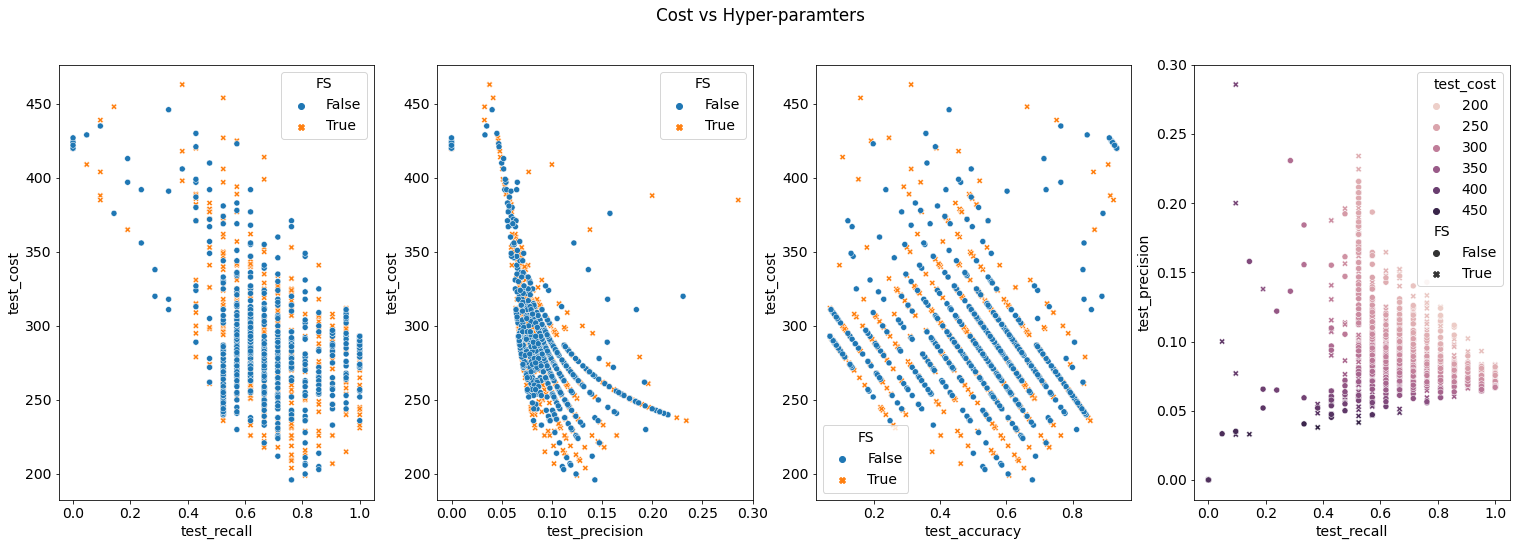

In [49]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 4, figsize=(26, 8))

fig.suptitle('Cost vs Hyper-paramters')
sns.scatterplot(ax=axes[0], data=df_scores, x='test_recall', y='test_cost', style='FS', hue='FS')
sns.scatterplot(ax=axes[1], data=df_scores, x='test_precision', y='test_cost', style='FS', hue='FS')
sns.scatterplot(ax=axes[2], data=df_scores, x='test_accuracy', y='test_cost', style='FS', hue='FS')
sns.scatterplot(ax=axes[3], data=df_scores, x='test_recall', y='test_precision', style='FS', hue='test_cost')

In [17]:
px.scatter_3d(df_scores, x='test_recall', y='test_precision', z='test_cost', color='test_cost', size='test_accuracy', opacity=1, width=1000, height=800)


NameError: name 'px' is not defined

<AxesSubplot:xlabel='test_auc', ylabel='test_accuracy'>

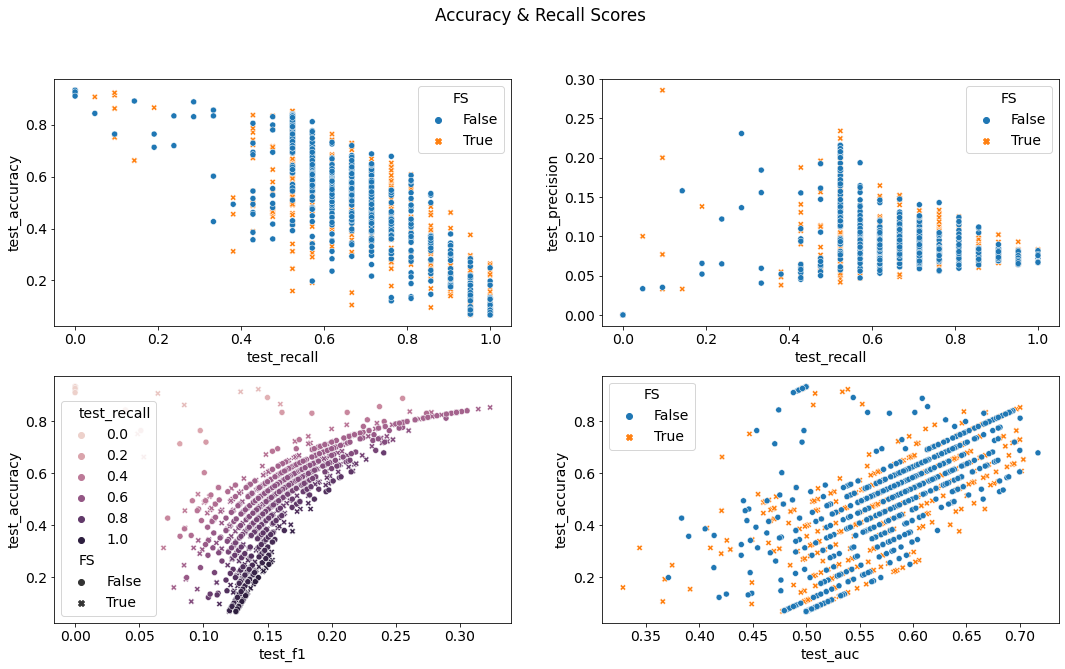

In [18]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

fig.suptitle('Accuracy & Recall Scores')

sns.scatterplot(ax=axes[0, 0], data=df_scores, x='test_recall', y='test_accuracy', style='FS', hue='FS')
sns.scatterplot(ax=axes[0, 1], data=df_scores, x='test_recall', y='test_precision', style='FS', hue='FS')
sns.scatterplot(ax=axes[1, 0], data=df_scores, x='test_f1', y='test_accuracy', style='FS', hue='test_recall')
sns.scatterplot(ax=axes[1, 1], data=df_scores, x='test_auc', y='test_accuracy', style='FS', hue='FS')

<AxesSubplot:xlabel='test_recall', ylabel='test_accuracy'>

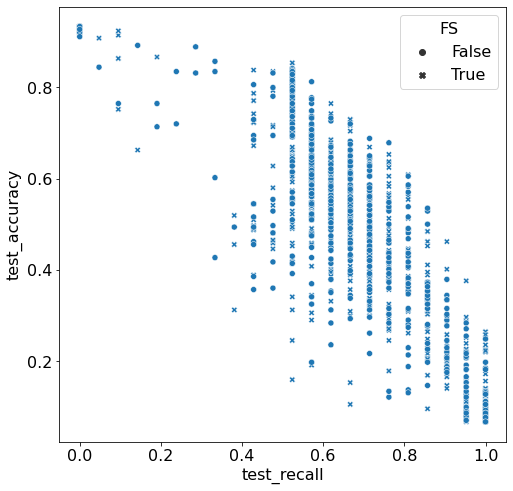

In [49]:
sns.scatterplot(data=df_scores, x='test_recall', y='test_accuracy', style='FS')

In [21]:
df_scores.to_csv('df_scores_with_FS.csv')

<AxesSubplot:xlabel='train_recall', ylabel='train_precision'>

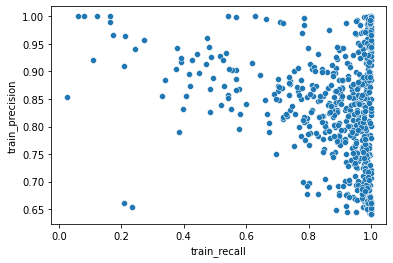

In [115]:
sns.scatterplot(data=df_scores, x='train_recall', y='train_precision')

In [ ]:
df_scores[df_scores['test_recall']]

<AxesSubplot:xlabel='test_recall', ylabel='test_accuracy'>

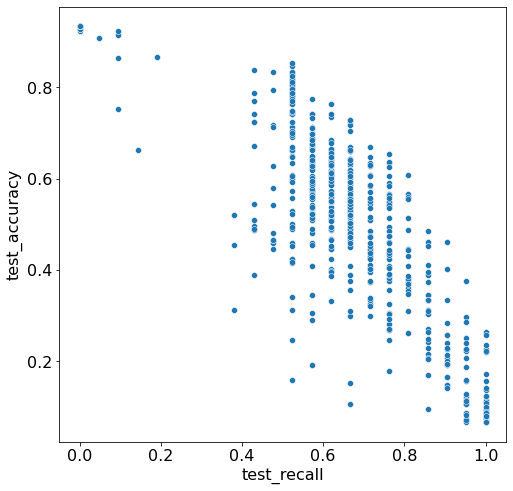

In [33]:
sns.scatterplot(data=df_scores, x='test_recall', y='test_accuracy')

In [9]:
plt.rcParams.update({'font.size': 14})
df_reshaped = pd.pivot_table(df_scores, values='test_accuracy', index='batch_size', columns='epochs', aggfunc=np.mean)
sns.heatmap(df_reshaped, annot=True)

# pivot only works if index does not have duplicated values
# df_reshaped = df_scores.pivot(index='batch_size',columns='epochs',values='test_accuracy')


NameError: name 'df_scores' is not defined

<AxesSubplot:xlabel='epochs', ylabel='batch_size'>

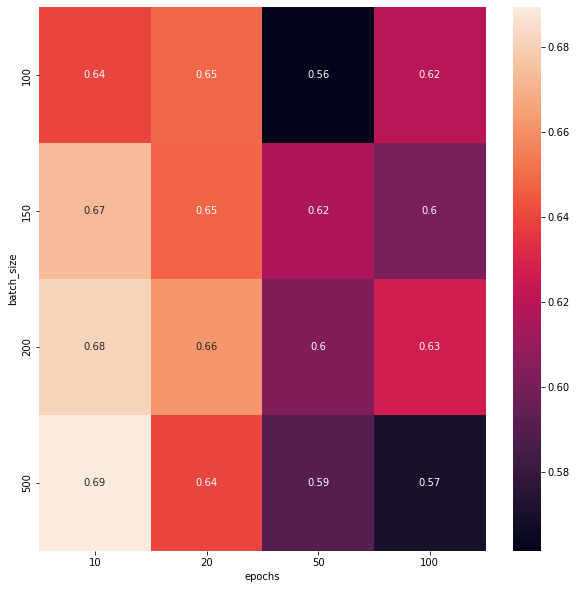

In [135]:
df_reshaped = pd.pivot_table(df_scores, values='test_recall', index='batch_size', columns='epochs', aggfunc=np.mean)
sns.heatmap(df_reshaped, annot=True)


<AxesSubplot:xlabel='neurons', ylabel='activation'>

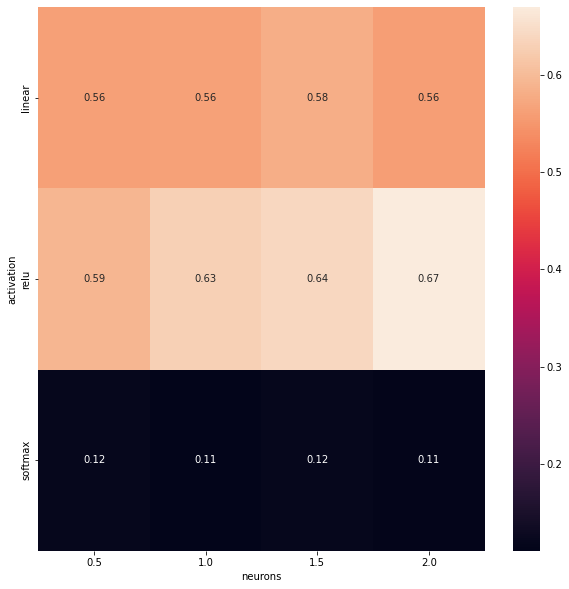

In [136]:
df_reshaped = pd.pivot_table(df_scores, values='test_accuracy', index='activation', columns='neurons', aggfunc=np.mean)
sns.heatmap(df_reshaped, annot=True)


<AxesSubplot:xlabel='neurons', ylabel='activation'>

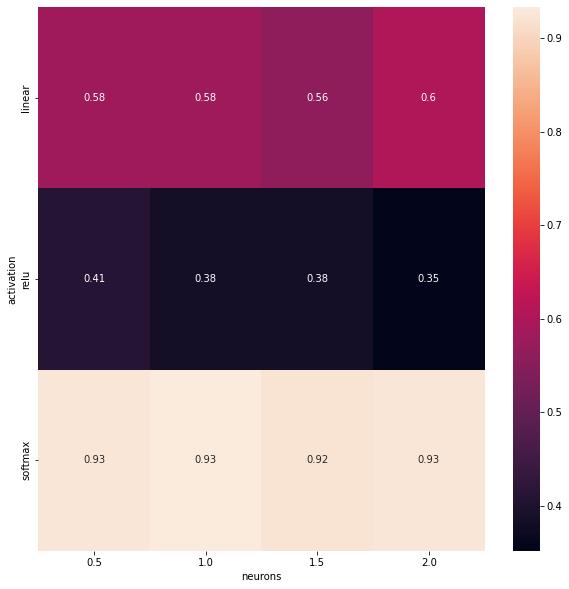

In [137]:
df_reshaped = pd.pivot_table(df_scores, values='test_recall', index='activation', columns='neurons', aggfunc=np.mean)
sns.heatmap(df_reshaped, annot=True)


<AxesSubplot:xlabel='dropout_rate', ylabel='activation'>

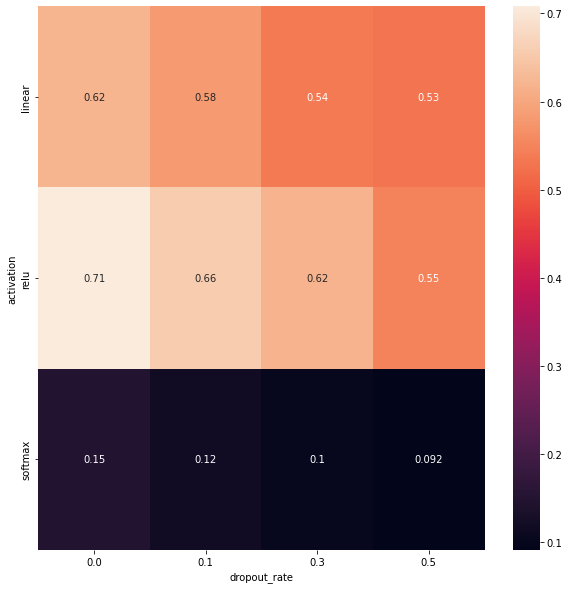

In [139]:
df_reshaped = pd.pivot_table(df_scores, values='test_accuracy', index='activation', columns='dropout_rate', aggfunc=np.mean)
sns.heatmap(df_reshaped, annot=True)


In [125]:
df_grouped = df_scores.groupby(by=['batch_size', 'epochs', 'neurons']).agg({'test_accuracy':['mean'], 'test_recall':['mean']})
df_grouped.reset_index(inplace=True)
df_grouped.columns = ['batch_size','epochs', 'neurons', 'test_accuracy_mean', 'test_recall_mean']

In [169]:
fig = px.scatter_3d(df_grouped, x='batch_size', y='epochs', z='neurons', color='test_accuracy_mean', size='test_recall_mean')
fig.show()

In [38]:
df_scores.sort_values('test_accuracy', ascending=False)

,hyperparam,train_cf_matrix,train_accuracy,train_f1,train_precision,train_recall,train_auc,train_log_loss,train_cohen_kappa_score,test_cf_matrix,test_accuracy,test_f1,test_precision,test_recall,test_auc,test_log_loss,test_cohen_kappa_score
30,"{'batch_size': 100, 'epochs': 50, 'activation'...","[[647, 1], [564, 596]]",0.687500,0.678429,0.998325,0.513793,0.756125,10.793368,0.429833,"[[281, 12], [18, 3]]",0.904459,0.166667,0.200000,0.142857,0.550951,3.299914,0.117482
20,"{'batch_size': 100, 'epochs': 50, 'activation'...","[[636, 12], [759, 401]]",0.573562,0.509854,0.970944,0.345690,0.663586,14.728654,0.260818,"[[270, 23], [18, 3]]",0.869427,0.127660,0.115385,0.142857,0.532179,4.509899,0.057954
21,"{'batch_size': 100, 'epochs': 50, 'activation'...","[[629, 19], [812, 348]]",0.540376,0.455796,0.948229,0.300000,0.635340,15.874855,0.213121,"[[269, 24], [20, 1]]",0.859873,0.043478,0.040000,0.047619,0.482854,4.839890,-0.031507
17,"{'batch_size': 100, 'epochs': 20, 'activation'...","[[619, 29], [256, 904]]",0.842367,0.863832,0.968917,0.779310,0.867279,5.444455,0.681844,"[[254, 39], [18, 3]]",0.818471,0.095238,0.071429,0.142857,0.504876,6.269877,0.006660
12,"{'batch_size': 100, 'epochs': 20, 'activation'...","[[614, 34], [160, 1000]]",0.892699,0.911577,0.967118,0.862069,0.904800,3.706056,0.776288,"[[253, 40], [17, 4]]",0.818471,0.123077,0.090909,0.190476,0.526979,6.269880,0.035772
18,"{'batch_size': 100, 'epochs': 50, 'activation'...","[[583, 65], [369, 791]]",0.759956,0.784722,0.924065,0.681897,0.790794,8.290863,0.527023,"[[249, 44], [15, 6]]",0.812102,0.169014,0.120000,0.285714,0.567772,6.489882,0.082599
22,"{'batch_size': 100, 'epochs': 50, 'activation'...","[[558, 90], [269, 891]]",0.801438,0.832321,0.908257,0.768103,0.814607,6.858126,0.593060,"[[243, 50], [12, 9]]",0.802548,0.225000,0.152542,0.428571,0.628961,6.819886,0.140182
2,"{'batch_size': 100, 'epochs': 20, 'activation'...","[[595, 53], [627, 533]]",0.623894,0.610538,0.909556,0.459483,0.688846,12.990271,0.315932,"[[246, 47], [16, 5]]",0.799363,0.136986,0.096154,0.238095,0.538843,6.929874,0.046099
33,"{'batch_size': 100, 'epochs': 50, 'activation'...","[[637, 11], [6, 1154]]",0.990597,0.992688,0.990558,0.994828,0.988926,0.324761,0.979520,"[[244, 49], [16, 5]]",0.792994,0.133333,0.092593,0.238095,0.535430,7.149871,0.040974
23,"{'batch_size': 100, 'epochs': 50, 'activation'...","[[550, 98], [313, 847]]",0.772677,0.804751,0.896296,0.730172,0.789469,7.851502,0.539439,"[[239, 54], [11, 10]]",0.792994,0.235294,0.156250,0.476190,0.645945,7.149884,0.149654


In [39]:
df_scores.to_csv('df_scores.csv')

In [ ]:
#without FS
cfm [[181 112]
 [ 11  10]]
acc 0.60828025477707

#with FS
Best scores: 0.644106 (+-0.286622) using {'activation': 'linear', 'batch_size': 100, 'dropout_rate': 0, 'epochs': 100, 'neurons': 10}
cfm [[182 111]
 [  8  13]]
acc 0.6210191082802548
recall_score 0.6190476190476191